In [1]:
# imports
import torch
from torch import Tensor, nn
from dataclasses import dataclass, field
from enum import Enum, auto
from itertools import count
from random import choice, getrandbits
from typing import NamedTuple
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib widget
import gymnasium as gym
from collections import defaultdict
from pprint import pprint
from copy import deepcopy

device: torch.device = torch.device("cpu")
torch.set_grad_enabled(False)
torch.rand((5, 8))

tensor([[0.4962, 0.7260, 0.3434, 0.5726, 0.6840, 0.3507, 0.1515, 0.1261],
        [0.6649, 0.6773, 0.9650, 0.6930, 0.7719, 0.9201, 0.2150, 0.9311],
        [0.5155, 0.5134, 0.3238, 0.5956, 0.9663, 0.8659, 0.1116, 0.7561],
        [0.7578, 0.2807, 0.7551, 0.7482, 0.5294, 0.3701, 0.6980, 0.5515],
        [0.0616, 0.2375, 0.1809, 0.9188, 0.1110, 0.0611, 0.6296, 0.3027]])

In [2]:
# utils
def rand_bool(*_) -> bool:
    return bool(getrandbits(1))

In [3]:
# Genes

from typing import ClassVar


class NodeType(Enum):
    INPUT = auto()
    HIDDEN = auto()
    OUTPUT = auto()
    BIAS = auto()


# class Activation(Enum):
#     Identity = auto()
#     Sigmoid = auto()
#     ReLU = auto()
#     Tanh = auto()


# def activate(activation: Activation, input: Tensor, **kwargs) -> Tensor:
#     match activation:
#         case Activation.Identity:
#             return input
#         case Activation.Sigmoid:
#             return torch.sigmoid(input, **kwargs)
#         case Activation.ReLU:
#             return torch.relu(input, **kwargs)
#         case Activation.Tanh:
#             return torch.tanh(input, **kwargs)
#         case _:
#             raise NotImplementedError

class NodePair(NamedTuple):
    in_index: int
    out_index: int


@dataclass
class ConnectionGene:
    nodes: NodePair
    weight: float = 1.0
    enabled: bool = True
    innovation: int = field(init=False)
    global_innovation_incr: ClassVar[count] = count()
    global_innovation_generation: ClassVar[defaultdict[NodePair, int]] = defaultdict(lambda: ConnectionGene.global_innovation_incr.__next__())

    def __post_init__(self):
        self.innovation = ConnectionGene.global_innovation_generation[self.nodes]

    def on(self) -> bool:
        return self.enabled
    
    def innov(self) -> int:
        return self.innovation

    @classmethod
    def reset_global_innovation(cls):
        cls.global_innovation_incr = count()
        cls.global_innovation_generation.clear()

    @classmethod
    def reset_generation_innovation(cls):
        cls.global_innovation_generation.clear()

In [4]:
from random import shuffle


class Genome(nn.Module):
    # these are just the attributes that are used in the forward pass
    node_vals: Tensor
    input_indices: Tensor
    hidden_indices: Tensor
    output_indices: Tensor
    forward_adj_mat: Tensor
    recurrent_connections: Tensor

    # Initialization

    def __init__(
        self,
        nodes: list[NodeType],
        connections: dict[NodePair, ConnectionGene] | list[ConnectionGene],
        # hidden_activation: Activation = Activation.ReLU,
        # output_activation: Activation = Activation.Sigmoid,
    ) -> None:
        super().__init__()
        self.nodes: list[NodeType] = nodes
        self.connections: dict[NodePair, ConnectionGene]
        match connections:
            case dict(x):
                self.connections = x
            case list(x):
                self.connections = {x.nodes: x for x in connections}
        if not any(filter(ConnectionGene.on, self.connections.values())):  # type: ignore
            print(
                f"WARNING: connections should not be all off:\n{self.connections=}\n{connections=}"
            )
        # self.hidden_activation: Activation = hidden_activation
        # self.output_activation: Activation = output_activation
        self.calculate_evalution_info()

    @classmethod
    def new_initial(cls, input_nodes: int, output_nodes: int) -> "Genome":
        weights: Tensor = torch.rand((input_nodes, output_nodes)) * 2 - 1
        nodes: list[NodeType] = [NodeType.INPUT for _ in range(input_nodes)] + [
            NodeType.OUTPUT for _ in range(output_nodes)
        ]
        connections: list[ConnectionGene] = [
            ConnectionGene(NodePair(i, input_nodes + j), weights[i, j].item())
            for i in range(input_nodes)
            for j in range(output_nodes)
        ]
        # print(nodes, connections)
        return Genome(nodes, connections)

    # Evaluation

    def calculate_evalution_info(self) -> None:
        self.node_vals: Tensor = torch.zeros(len(self.nodes), device=device)
        input_indices_list: list[int] = []
        hidden_indices_list: list[int] = []
        output_indices_list: list[int] = []
        connection_mat: Tensor = torch.tensor(
            [(*x.nodes, x.weight) for x in self.connections.values() if x.enabled]
        ).T
        self.adj_mat_full: Tensor
        adj_mat_full_shape: tuple[int, int] = (len(self.nodes), len(self.nodes))
        if connection_mat.any():
            self.adj_mat_full = torch.sparse_coo_tensor(
                connection_mat[:2],
                connection_mat[2],
                device=device,
                size=adj_mat_full_shape,
            ).T.coalesce()
        else:
            self.adj_mat_full = torch.zeros(adj_mat_full_shape, layout=torch.sparse_coo, device=device)
        recurrent_connections: set[NodePair] = set()
        finished_nodes: set[int] = set()
        visited_nodes: set[int] = set()
        for i, x in enumerate(self.nodes):
            visited_nodes.add(i)
            match x:
                case NodeType.INPUT:
                    input_indices_list.append(i)
                    finished_nodes.add(i)
                case NodeType.OUTPUT:
                    output_indices_list.append(i)
                case NodeType.HIDDEN:
                    hidden_indices_list.append(i)
                    curr_inputs: set[int] = set(
                        self.adj_mat_full[i].coalesce().indices()[0].tolist()
                    )
                    # if not curr_inputs:
                    # print(f"theres a hidden node with no inputs :/ {i=}")
                    if finished_nodes.issuperset(curr_inputs):
                        finished_nodes.add(i)
                    else:
                        recurrent_connections.update(
                            NodePair(j, i) for j in curr_inputs - finished_nodes
                        )
                case NodeType.BIAS:
                    self.node_vals[i] = 1.0
                    raise NotImplementedError
        self.input_indices: Tensor = torch.tensor(
            input_indices_list, device=device, dtype=torch.int
        )
        self.hidden_indices: Tensor = torch.tensor(
            hidden_indices_list, device=device, dtype=torch.int
        )
        self.output_indices: Tensor = torch.tensor(
            output_indices_list, device=device, dtype=torch.int
        )
        adj_mat: Tensor = self.adj_mat_full.to_dense()
        # print(f"{adj_mat=} {adj_mat.shape=}\n{recurrent_adjacencies=} {recurrent_adjacencies.shape=}\n{adj_mat[recurrent_adjs_list]=} {adj_mat[recurrent_adjs_list].flatten()=}")
        if recurrent_connections:
            recurrent_adjacencies: Tensor = torch.tensor(
                list(recurrent_connections), device=device
            ).T.flip(0)
            recurrent_adjs_list: list[int] = recurrent_adjacencies.tolist()
            if (recurrent_adjacencies >= adj_mat.shape[0]).any():
                print(
                    f"WARNING: recurrent connections are out of bounds\n{recurrent_adjs_list=}\n{adj_mat=}\n{self.connections=}\n{recurrent_connections=}\n{self.nodes=}\n{adj_mat.shape=} {recurrent_adjacencies.shape=}\n"
                )
            self.recurrent_connections: Tensor = torch.sparse_coo_tensor(
                indices=recurrent_adjacencies,
                values=adj_mat[recurrent_adjs_list],
                size=adj_mat.shape,
                device=device,
            )
            adj_mat[recurrent_adjs_list] = 0
        else:
            self.recurrent_connections: Tensor = torch.empty(
                adj_mat.shape, layout=torch.sparse_coo, device=device
            )
        assert not adj_mat[
            :, self.output_indices
        ].any(), f"All connections from an output node should be in the recurrent mat, not the general one.\nn{adj_mat=}"
        assert not self.adj_mat_full.to_dense()[
            self.input_indices
        ].any(), "There should be no connections going to input nodes"
        assert not self.recurrent_connections.to_dense()[
            self.output_indices, self.output_indices
        ], "There should be no connections from output node to output node"
        self.forward_adj_mat: Tensor = adj_mat.to_sparse_coo()
        assert self.adj_mat_full.shape == self.forward_adj_mat.shape

    def forward(self, input: Tensor) -> Tensor:
        self.node_vals[self.input_indices] = input
        forward_adj = self.forward_adj_mat.to_dense()
        self.node_vals[self.hidden_indices] = (
            self.node_vals[self.hidden_indices]
            .addmv(forward_adj[self.hidden_indices], self.node_vals)
            .relu()
        )
        outs = self.node_vals[self.output_indices] = torch.sigmoid(
            forward_adj[self.output_indices] @ self.node_vals
        )
        self.node_vals += self.recurrent_connections @ self.node_vals
        return outs

    def reset_nodevals(self) -> None:
        self.node_vals.zero_()

    # Mutations
    # currently doesn't support removing nodes bc it's a pain

    def add_connection(
        self,
        in_node: int | None = None,
        out_node: int | None = None,
        weight: float | None = None,
    ) -> bool:
        """tries to add a connection, randomized values if not provided

        returns False on failure(enabling an already-enabled connection)"""
        if in_node is None or out_node is None:
            possible_outputs = [
                i for i, x in enumerate(self.nodes) if x is not NodeType.INPUT
            ]
            if out_node is None:
                out_node = choice(possible_outputs)
            if in_node is None:
                possible_inputs: list[int] = (
                    possible_outputs + self.input_indices.tolist()
                )
                assert not any(x >= len(self.nodes) for x in possible_inputs)
                possible_inputs.remove(out_node)
                in_node = choice(possible_inputs)
        node_pair = NodePair(in_node, out_node)
        weight = weight or (torch.rand(1) * 2 - 1).item()
        connection_exists_disabled: bool = False
        if existing_connection := self.connections.get(node_pair):
            connection_exists_disabled = not existing_connection.enabled
            existing_connection.enabled = True
        else:
            self.connections[node_pair] = ConnectionGene(node_pair, weight)
        self.calculate_evalution_info()
        return not connection_exists_disabled

    def remove_connection(self, connection_to_remove: NodePair | None = None) -> bool:
        """removes a connection, returns False if there are <2 connections or if randomly selecting and there are <2 enabled connections, True otherwise"""
        if len(self.connections) < 2:
            return False
        if connection_to_remove is None:
            possible_keys: list[NodePair] = [
                k for k, v in self.connections.items() if v.enabled
            ]
            if len(possible_keys) < 2:
                return False
            connection_to_remove = choice(possible_keys)
        self.connections[connection_to_remove].enabled = False
        self.calculate_evalution_info()
        return True

    def add_node(self, connection_to_split: NodePair | None = None) -> None:
        if connection_to_split is None:
            # for some reason i have to separate this otherwise type checker doesnt work
            possible_keys: list[NodePair] = list(self.connections.keys())
            connection_to_split = choice(possible_keys)
        splitter: ConnectionGene = self.connections[connection_to_split]
        splitter.enabled = False
        new_node_index: int = len(self.nodes)
        self.nodes.append(NodeType.HIDDEN)
        in_nodes, out_nodes = NodePair(
            splitter.nodes.in_index, new_node_index
        ), NodePair(new_node_index, splitter.nodes.out_index)
        self.connections[in_nodes] = ConnectionGene(in_nodes, 1.0)
        self.connections[out_nodes] = ConnectionGene(out_nodes, splitter.weight)
        self.calculate_evalution_info()

    # def remove_node(self, node_index: int | None = None) -> bool:
    #     """"removes" a node by disabling all connections to and from it, returns False if the node is an input or output node or if there are no hidden nodes, True otherwise"""
    #     if (node_index and not node_index in self.hidden_indices) or len(self.hidden_indices) == 0:
    #         return False
    #     for k, v in self.connections.items():
    #         if node_index in k:
    #             v.enabled = False
    #     self.calculate_evalution_info()
    #     return True

    def perturb_weights(self, mu: float = 0, sigma: float = 0.5) -> None:
        delta_weights = torch.normal(mu, sigma, (len(self.connections),))
        for x, delta_weight in zip(self.connections.values(), delta_weights):
            x.weight += delta_weight.item()
        self.calculate_evalution_info()

    def mutate(
        self,
        p_new_node: float = 0.03,
        # p_remove_node: float = 0.05,
        p_new_connection: float = 0.15,
        p_remove_connection: float = 0.1,
        p_perturb_weight: float = 0.35,
    ) -> None:
        match torch.multinomial(
            torch.tensor(
                [p_new_node, 0, p_new_connection, p_remove_connection, p_perturb_weight]
            ),
            1,
        ).item():
            case 0:
                self.add_node()
            case 2:
                _ = self.add_connection() or self.perturb_weights()
            case 3:
                _ = self.remove_connection() or self.perturb_weights()
            case 4:
                self.perturb_weights()

    # Display

    def make_graph(self) -> nx.DiGraph:
        graph: nx.DiGraph = nx.DiGraph(
            [
                (input, output, {"weight": x.weight})
                for ((input, output), x) in self.connections.items()
            ]
        )
        for i, x in graph.nodes.items():
            layer: float
            match self.nodes[i]:
                case NodeType.INPUT:
                    layer = -1e10
                case NodeType.HIDDEN | NodeType.BIAS:
                    layer = -max(
                        nx.edge_connectivity(graph, i, int(j))
                        for j in self.output_indices
                    )
                case NodeType.OUTPUT:
                    layer = 1e10
                case _:
                    raise NotImplementedError
            x["group"] = layer
        graph.graph["pos"] = nx.drawing.layout.multipartite_layout(
            graph, subset_key="group"
        )
        # graph.graph["pos"] = nx.drawing.nx_agraph.graphviz_layout(graph, prog="dot", args="-Grankdir=LR -Gordering=out")
        # graph.graph["pos"] = nx.drawing.layout.spectral_layout(graph)
        graph.graph["edge_labels"] = dict(
            (k, round(v["weight"], 3)) for k, v in graph.edges.items()
        )
        return graph

    def draw(self, ax: Axes):
        graph: nx.DiGraph = self.make_graph()
        nx.draw_networkx(graph, pos=graph.graph["pos"], ax=ax)
        nx.draw_networkx_edge_labels(
            graph,
            pos=graph.graph["pos"],
            edge_labels=graph.graph["edge_labels"],
            label_pos=0.25,
            ax=ax,
        )

    # Evolution

    def crossover(self, other: "Genome", equal_fitness: bool = False) -> "Genome":  # type: ignore
        """Crosses over with a EQUALLY- OR LESS-FIT genome to produce a child"""
        assert (self.input_indices == other.input_indices).all()
        assert (self.output_indices == other.output_indices).all()
        if self.connections == other.connections:
            return deepcopy(self)
        connections: dict[NodePair, ConnectionGene] = deepcopy(self.connections)
        self_innovations: set[int] = {x.innovation for x in self.connections.values()}
        other_connections_masked = filter(rand_bool, other.connections.items())
        if equal_fitness:
            connections.update(other_connections_masked)
        else:
            # only cross matching genes from less fit genome
            connections.update(
                (
                    x
                    for x in other_connections_masked
                    if x[1].innovation in self_innovations
                )
            )
        # if not any(filter(ConnectionGene.on, connections.values())):  # type: ignore
        #     # print(
        #     #     f"WARNING: connections should not be all off:\n{self.connections=}\n{other.connections=}\n{connections=}\ngonna enable some random ones"
        #     # )
        #     disabled_connections = list(filter(ConnectionGene.on, connections.values()))
        #     shuffle(disabled_connections)
        #     for x in disabled_connections[: min(2, len(disabled_connections))]:
        #         x.enabled = True
        last_fitter_node: int = len(self.nodes) - 1
        nodes: list[NodeType] = self.nodes.copy() + [NodeType.HIDDEN] * max(
            max(in_index - last_fitter_node, out_index - last_fitter_node, 0)
            for in_index, out_index in connections.keys()
        )
        # print(f"{last_fitter_node=} {nodes=}\n{connections=}")
        return Genome(nodes, connections)

    def distance(
        self, other: "Genome", c1: float = 1.0, c2: float = 1.0, c3: float = 0.4
    ) -> float:
        gene_count_self: int = len(self.connections)
        gene_count_other: int = len(other.connections)
        if gene_count_self < 20 and gene_count_other < 20:
            N_genes_larger: int = 1
        else:
            N_genes_larger: int = max(len(self.connections), len(other.connections))
        max_innov_self: int = max(map(ConnectionGene.innov, self.connections.values()))
        max_innov_other: int = max(
            map(ConnectionGene.innov, other.connections.values())
        )
        pairs_self = self.connections.keys()
        pairs_other = other.connections.keys()
        excess_count: int = sum(
            self.connections[x].innovation > max_innov_other
            for x in pairs_self - pairs_other
        ) + sum(
            other.connections[x].innovation > max_innov_self
            for x in pairs_other - pairs_self
        )
        disjoint_count: int = len(pairs_self ^ pairs_other) - excess_count
        matching_genes: set[NodePair] = (
            self.connections.keys() & other.connections.keys()
        )
        avg_weight_diff: float = sum(
            abs(self.connections[x].weight - other.connections[x].weight)
            for x in matching_genes
        ) / len(matching_genes)
        # print(f"{c1} * {excess_count} / {N_genes_larger} + {c2} * {disjoint_count} / {N_genes_larger} + {c3} * {avg_weight_diff}")
        return (
            c1 * excess_count / N_genes_larger
            + c2 * disjoint_count / N_genes_larger
            + c3 * avg_weight_diff
        )

In [5]:
# little bit of testing
nodes = [
    NodeType.INPUT,
    NodeType.INPUT,
    NodeType.INPUT,
    NodeType.INPUT,
    NodeType.OUTPUT,
    NodeType.HIDDEN,
]
a = Genome(
    nodes,
    [
        ConnectionGene(NodePair(1, 4), 0.25),
        ConnectionGene(NodePair(2, 4), 0.55),
        ConnectionGene(NodePair(2, 5), 0.78),
        ConnectionGene(NodePair(1, 5), 0.2),
    ],
)
b = Genome(
    nodes,
    [
        ConnectionGene(NodePair(1, 4), 0.25),
        ConnectionGene(NodePair(2, 4), 0.55),
        ConnectionGene(NodePair(2, 5), 0.78),
        ConnectionGene(NodePair(1, 5), 0.2),
    ],
)
assert a.distance(b) == 0
assert a.crossover(b).connections == a.connections
assert b.crossover(a).connections == b.connections
b = Genome(
    nodes,
    [
        ConnectionGene(NodePair(1, 4), 0.15),
        ConnectionGene(NodePair(3, 4), 0.92),
        ConnectionGene(NodePair(5, 4), 0.37),
    ],
)
assert a.distance(b, 1.0, 1.0, 0.4) == 1.0 * 1 / 1 + 1.0 * 4 / 1 + 0.4 * 0.1
print(a.distance(b))
# print(a(torch.rand(4)))
a.add_node(NodePair(1, 4))
example_input = torch.tensor([1., 2, 3, 4], device=device)
assert a(example_input).item() == 0.8956687450408936
a.add_connection(5, 4)
# print(a.connections)
a.add_connection(4, 5)
a.add_connection(5, 6)
a(example_input)
a.add_node(NodePair(5, 4))
a(example_input)
a.add_connection(6, 7)
a.add_connection(2, 6)
a(example_input)
a(example_input)
# a.draw(plt.figure(clear=True).add_subplot())
# plt.show()
print(a.connections)
a = ConnectionGene(NodePair(1, 4), 0.25)
b = ConnectionGene(NodePair(1, 4), 0.25)
ConnectionGene.reset_generation_innovation()
c = ConnectionGene(NodePair(1, 4), 0.25)
print(a, b, c, sep="\n")
del a, b, c, example_input
ConnectionGene.reset_global_innovation()

5.04
{NodePair(in_index=1, out_index=4): ConnectionGene(nodes=NodePair(in_index=1, out_index=4), weight=0.25, enabled=False, innovation=0), NodePair(in_index=2, out_index=4): ConnectionGene(nodes=NodePair(in_index=2, out_index=4), weight=0.55, enabled=True, innovation=1), NodePair(in_index=2, out_index=5): ConnectionGene(nodes=NodePair(in_index=2, out_index=5), weight=0.78, enabled=True, innovation=2), NodePair(in_index=1, out_index=5): ConnectionGene(nodes=NodePair(in_index=1, out_index=5), weight=0.2, enabled=True, innovation=3), NodePair(in_index=1, out_index=6): ConnectionGene(nodes=NodePair(in_index=1, out_index=6), weight=1.0, enabled=True, innovation=6), NodePair(in_index=6, out_index=4): ConnectionGene(nodes=NodePair(in_index=6, out_index=4), weight=0.25, enabled=True, innovation=7), NodePair(in_index=5, out_index=4): ConnectionGene(nodes=NodePair(in_index=5, out_index=4), weight=-0.47133052349090576, enabled=False, innovation=5), NodePair(in_index=4, out_index=5): ConnectionGe

In [11]:
# That's the NEAT part (TORCHRL ENVS):
INITIAL_POP_SIZE: int = 50
MAX_POP_SIZE: int = 80
MIN_EPISODES: int = 5
N_EPOCHS: int = 20
PARENT_RATE: float = 0.2
SPECIES_THRESHOLD_INIT: float = 2.5
SPECIES_THRESHOLD_FINAL: float | None = None
SPECIES_THRESHOLD_DECAY: float | None = SPECIES_THRESHOLD_FINAL and (
    SPECIES_THRESHOLD_FINAL / SPECIES_THRESHOLD_INIT
) ** (1 / N_EPOCHS)
KEEP_BEST_OVERALL: int = 2
ConnectionGene.reset_global_innovation()

gs: list[Genome] = [Genome.new_initial(4, 1) for _ in range(INITIAL_POP_SIZE)]
rewards_overall: list[Tensor] = []
shared_rewards_overall: list[Tensor] = []
species_overall: list[list[list[int]]] = []
species_threshold_curr: float = SPECIES_THRESHOLD_INIT

import tensordict
from torchrl import torchrl

def make_cartpole():
    return torchrl.envs.GymEnv("CartPole-v1")

envs = torchrl.envs.SerialEnv(MAX_POP_SIZE, make_cartpole, device=device)

def play_episodes(gs: list[Genome]) -> Tensor:
    pop_size = len(gs)
    assert pop_size <= MAX_POP_SIZE
    epoch_rewards = torch.zeros(pop_size, dtype=torch.float, device=device)
    episodes = torch.zeros(pop_size, dtype=torch.long)
    curr_rewards = torch.zeros(pop_size, dtype=torch.float)
    global envs, once
    data_: tensordict.TensorDictBase = envs.reset()
    # display(data_)
    while (episodes < MIN_EPISODES).any():
        data_["action"] = torch.zeros((MAX_POP_SIZE, 1), dtype=torch.int, device=device)
        activations = torch.stack([g(obs) for g, obs in zip(gs, data_["observation"])])
        data_["action"][:pop_size] = activations.round().int()
        data, data_ = envs.step_and_maybe_reset(data_)
        curr_rewards += data["next"]["reward"].squeeze()[:pop_size]
        dones = data["next"]["done"].squeeze()[:pop_size]
        if dones.any():
            episodes[dones] += 1
            epoch_rewards[dones] += curr_rewards[dones]
            curr_rewards[dones] = 0
            for i in dones.nonzero()[0]:
                gs[i.item()].reset_nodevals()
    epoch_rewards /= episodes
    return epoch_rewards


for epoch in range(N_EPOCHS):
    species = [[0]]
    for i in range(1, len(gs)):
        gs[i].reset_nodevals()
        for specie in species:
            if gs[i].distance(gs[choice(specie)]) < species_threshold_curr:
                specie.append(i)
                break
        else:
            species.append([i])
    # if len(gs) != sum(map(len, species)):
    # print(f"WARNING: species are not covering all genomes\n{len(gs)=}\n{species=}")

    species_overall.append(species)
    print(f"epoch {epoch} species:")
    pprint(species, compact=True)
    # PLAY EPISODES
    epoch_rewards = play_episodes(gs)
    rewards_overall.append(epoch_rewards.clone())
    print(f"rewards:\n{epoch_rewards}")
    shared_rewards = epoch_rewards
    for specie in species:
        shared_rewards[specie] /= len(specie)
    shared_rewards_overall.append(shared_rewards)
    rewards_sorted, g_indices_sorted = shared_rewards.sort(descending=True, stable=True)
    print(
        f"shared rewards sorted:\n{rewards_sorted}\nagents sorted:\n{g_indices_sorted}\n"
    )

    # no need to reproduce if its the last epoch
    if epoch == N_EPOCHS - 1:
        break

    gs_new: list[Genome] = [gs[i] for i in g_indices_sorted[:KEEP_BEST_OVERALL]]
    # gs_new: list[Genome] = []
    ConnectionGene.reset_generation_innovation()
    shared_reward_mean = shared_rewards.mean()
    new_species_sizes = sorted(
        (
            shared_rewards[specie].sum().div(shared_reward_mean).int().item()
            for specie in species
        ),
        reverse=True,
    )
    new_pop_size = int(KEEP_BEST_OVERALL + sum(new_species_sizes))
    if new_pop_size > MAX_POP_SIZE:
        print(
            f"WARNING: new_pop_size is {new_pop_size=} > {MAX_POP_SIZE=}, culling from each specie smallest -> biggest"
        )
        for i in range(new_pop_size - MAX_POP_SIZE):
            new_species_sizes[i] -= 1

    for specie, new_specie_size in zip(species, new_species_sizes):
        if not specie or new_specie_size == 0:
            print("Empty species")
            continue
        n_parents = max(min(3, len(specie)), int(len(specie) * PARENT_RATE))
        parent_indices = torch.multinomial(shared_rewards[specie][:n_parents], (new_specie_size * 2), True).reshape(-1, 2)  # type: ignore
        for parent1_index, parent2_index in parent_indices:
            child: Genome
            if parent1_index == parent2_index:
                child = deepcopy(gs[g_indices_sorted[parent1_index]])
            else:
                if rewards_sorted[parent1_index] < rewards_sorted[parent2_index]:
                    parent1_index, parent2_index = parent2_index, parent1_index
                parent1, parent2 = (
                    gs[g_indices_sorted[parent1_index]],
                    gs[g_indices_sorted[parent2_index]],
                )
                child = parent1.crossover(
                    parent2,
                    torch.allclose(
                        rewards_sorted[parent1_index], rewards_sorted[parent2_index]
                    ),
                )
            child.mutate()
            gs_new.append(child)
    gs = gs_new

    if SPECIES_THRESHOLD_DECAY:
        species_threshold_curr *= SPECIES_THRESHOLD_DECAY
envs.close()

d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('

epoch 0 species:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
  41, 42, 43, 44, 45, 46, 47, 48, 49]]


d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
d:\Python\Neat\.conda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('

tensor([[0.5235],
        [0.5115],
        [0.5122],
        [0.4863],
        [0.5060],
        [0.4928],
        [0.4936],
        [0.4935],
        [0.5059],
        [0.4884],
        [0.4969],
        [0.5223],
        [0.4810],
        [0.4994],
        [0.4973],
        [0.5009],
        [0.4962],
        [0.5090],
        [0.4818],
        [0.4950],
        [0.5002],
        [0.4953],
        [0.5012],
        [0.5002],
        [0.5036],
        [0.4962],
        [0.5046],
        [0.4947],
        [0.4874],
        [0.4903],
        [0.5052],
        [0.4874],
        [0.4963],
        [0.5090],
        [0.5028],
        [0.4915],
        [0.5004],
        [0.4962],
        [0.4988],
        [0.5033],
        [0.5051],
        [0.5014],
        [0.5043],
        [0.4976],
        [0.5170],
        [0.4992],
        [0.4925],
        [0.5053],
        [0.4996],
        [0.4955]])

tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

rewards:
tensor([ 9.2000,  9.6000,  9.4000, 10.0000,  9.0000,  9.2000,  9.4000,  8.8000,
         9.4000,  9.0000,  9.0000,  9.2000,  9.0000,  9.4000,  9.4000,  9.2000,
         9.4000,  9.4000,  9.8000,  9.6000,  9.8000,  9.2000,  9.2000,  9.2000,
         9.4000,  9.4000,  9.4000,  9.0000,  9.4000,  9.6000,  9.4000,  9.6000,
         9.4000,  9.8000,  9.0000,  9.4000,  8.4000,  9.4000,  9.0000,  9.4000,
         9.8000,  8.8000,  9.6000,  8.4000,  8.6000,  9.6000,  9.0000,  9.6000,
         9.6000,  9.2000])
shared rewards sorted:
tensor([0.2000, 0.1960, 0.1960, 0.1960, 0.1960, 0.1920, 0.1920, 0.1920, 0.1920,
        0.1920, 0.1920, 0.1920, 0.1920, 0.1880, 0.1880, 0.1880, 0.1880, 0.1880,
        0.1880, 0.1880, 0.1880, 0.1880, 0.1880, 0.1880, 0.1880, 0.1880, 0.1880,
        0.1880, 0.1880, 0.1840, 0.1840, 0.1840, 0.1840, 0.1840, 0.1840, 0.1840,
        0.1840, 0.1800, 0.1800, 0.1800, 0.1800, 0.1800, 0.1800, 0.1800, 0.1800,
        0.1760, 0.1760, 0.1720, 0.1680, 0.1680])
agents sorte

In [92]:
# That's the NEAT part (no torch parallelenv):
# note: good params 50, 3, 15, 0.2, 2.5, no decay, keep 2; takes ~4min
INITIAL_POP_SIZE: int = 25
MIN_EPISODES: int = 3
N_EPOCHS: int = 15
PARENT_RATE: float = 0.2
SPECIES_THRESHOLD_INIT: float = 2.5
SPECIES_THRESHOLD_DECAY_ON: bool = False
# SPECIES_THRESHOLD_FINAL: float = 1.5
# SPECIES_THRESHOLD_DECAY: float = (SPECIES_THRESHOLD_FINAL / SPECIES_THRESHOLD_INIT) ** (1 / N_EPOCHS)
KEEP_BEST_OVERALL: int = 2
ConnectionGene.reset_global_innovation()

gs: list[Genome] = [Genome.new_initial(4, 1) for _ in range(INITIAL_POP_SIZE)]
rewards_overall: list[Tensor] = []
shared_rewards_overall: list[Tensor] = []
species_overall: list[list[list[int]]] = []
species_threshold_curr: float = SPECIES_THRESHOLD_INIT


def play_episodes(gs: list[Genome]) -> Tensor:
    pop_size = len(gs)
    epoch_rewards = torch.zeros(pop_size, dtype=torch.float, device=device)
    episodes = torch.zeros(pop_size, dtype=torch.long, device=device)
    curr_rewards = torch.zeros(pop_size, dtype=torch.float, device=device)
    envs = gym.make_vec("CartPole-v1", num_envs=pop_size, vectorization_mode="sync")
    obs, _info = envs.reset()
    while (episodes < MIN_EPISODES).any():
        input = torch.as_tensor(obs, device=device)
        actions = torch.tensor(
            [x(y).round().bool() for x, y in zip(gs, input)],
            dtype=torch.int,
            device="cpu",
        ).numpy()
        obs, rewards, terms, truncs, _infos = envs.step(actions)
        curr_rewards += torch.as_tensor(rewards, device=device)
        dones = terms | truncs
        if dones.any():
            episodes[dones] += 1
            epoch_rewards[dones] += curr_rewards[dones]
            curr_rewards[dones] = 0
            for i in dones.nonzero()[0]:
                gs[i.item()].reset_nodevals()
            # if (episodes >= MIN_EPISODES).any():
            #     print(episodes)
    envs.close()
    epoch_rewards /= episodes
    return epoch_rewards


for epoch in range(N_EPOCHS):
    species = [[0]]
    for i in range(1, len(gs)):
        gs[i].reset_nodevals()
        for specie in species:
            if gs[i].distance(gs[choice(specie)]) < species_threshold_curr:
                specie.append(i)
                break
        else:
            species.append([i])
    species_overall.append(species)
    print(f"epoch {epoch} species:")
    pprint(species, compact=True)
    epoch_rewards = play_episodes(gs)
    rewards_overall.append(epoch_rewards.clone())
    print(f"rewards:\n{epoch_rewards}")
    shared_rewards = epoch_rewards
    for specie in species:
        shared_rewards[specie] /= len(specie)
    shared_rewards_overall.append(shared_rewards)
    rewards_sorted, g_indices_sorted = shared_rewards.sort(descending=True, stable=True)
    print(
        f"shared rewards sorted:\n{rewards_sorted}\nagents sorted:\n{g_indices_sorted}\n"
    )

    # no need to reproduce if its the last epoch
    if epoch == N_EPOCHS - 1:
        break

    gs_new: list[Genome] = [gs[i] for i in g_indices_sorted[:KEEP_BEST_OVERALL]]
    # gs_new: list[Genome] = []
    ConnectionGene.reset_generation_innovation()
    shared_reward_mean = shared_rewards.mean()
    for specie in species:
        # assert specie, f"what? {specie=}\n{species=}"
        n_parents = max(min(3, len(specie)), int(len(specie) * PARENT_RATE))
        new_specie_size = (
            shared_rewards[specie].sum().div(shared_reward_mean).round().int()
        )
        parent_indices = torch.multinomial(shared_rewards[specie][:n_parents], (new_specie_size * 2), True).reshape(-1, 2)  # type: ignore
        for parent1_index, parent2_index in parent_indices:
            child: Genome
            if parent1_index == parent2_index:
                child = deepcopy(gs[g_indices_sorted[parent1_index]])
            else:
                if rewards_sorted[parent1_index] < rewards_sorted[parent2_index]:
                    parent1_index, parent2_index = parent2_index, parent1_index
                child = gs[g_indices_sorted[parent1_index]].crossover(
                    gs[g_indices_sorted[parent2_index]],
                    torch.allclose(
                        rewards_sorted[parent1_index], rewards_sorted[parent2_index]
                    ),
                )
            child.mutate()
            gs_new.append(child)
    gs = gs_new
    if SPECIES_THRESHOLD_DECAY_ON:
        species_threshold_curr *= SPECIES_THRESHOLD_DECAY

epoch 0 species:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24]]
rewards:
tensor([500.0000,   9.4088,   9.4494,   9.6258,  53.2963,  88.2500,   9.9400,
         30.3878,   9.3687,   9.1341, 113.4615,  33.0222,   9.5223,   9.5962,
          9.5897,  20.4247,  55.2692, 500.0000,   9.5769, 172.8750, 163.5556,
         96.4000,   9.6323, 155.0000,  53.5000])
shared rewards sorted:
tensor([20.0000, 20.0000,  6.9150,  6.5422,  6.2000,  4.5385,  3.8560,  3.5300,
         2.2108,  2.1400,  2.1319,  1.3209,  1.2155,  0.8170,  0.3976,  0.3853,
         0.3850,  0.3838,  0.3836,  0.3831,  0.3809,  0.3780,  0.3764,  0.3747,
         0.3654])
agents sorted:
tensor([ 0, 17, 19, 20, 23, 10, 21,  5, 16, 24,  4, 11,  7, 15,  6, 22,  3, 13,
        14, 18, 12,  2,  1,  8,  9])

epoch 1 species:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24, 25, 26]]
rewards:
tensor([500.0000, 500.0000, 313.7500, 127.6364, 500.0

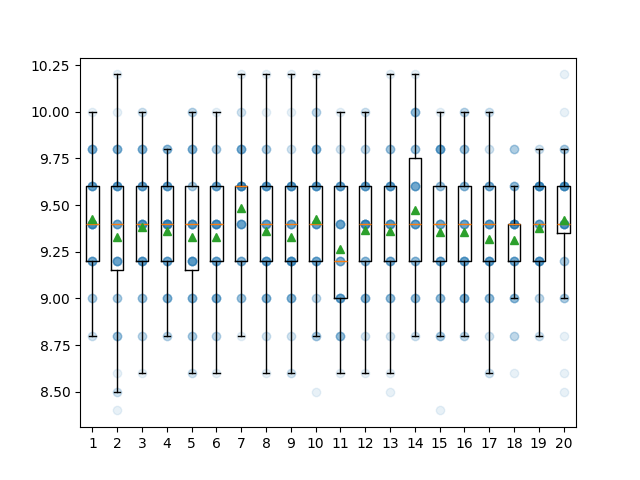

In [98]:
# Rewards plot
plt.figure(num="Rewards", clear=True)
max_pop_size = max(map(len, rewards_overall))
plt.scatter(
    torch.arange(len(rewards_overall)).repeat(max_pop_size, 1) + 1,
    nn.utils.rnn.pad_sequence(rewards_overall, padding_value=torch.nan),
    alpha=0.1,
)
plt.boxplot(rewards_overall, showfliers=False, showmeans=True)
plt.show()

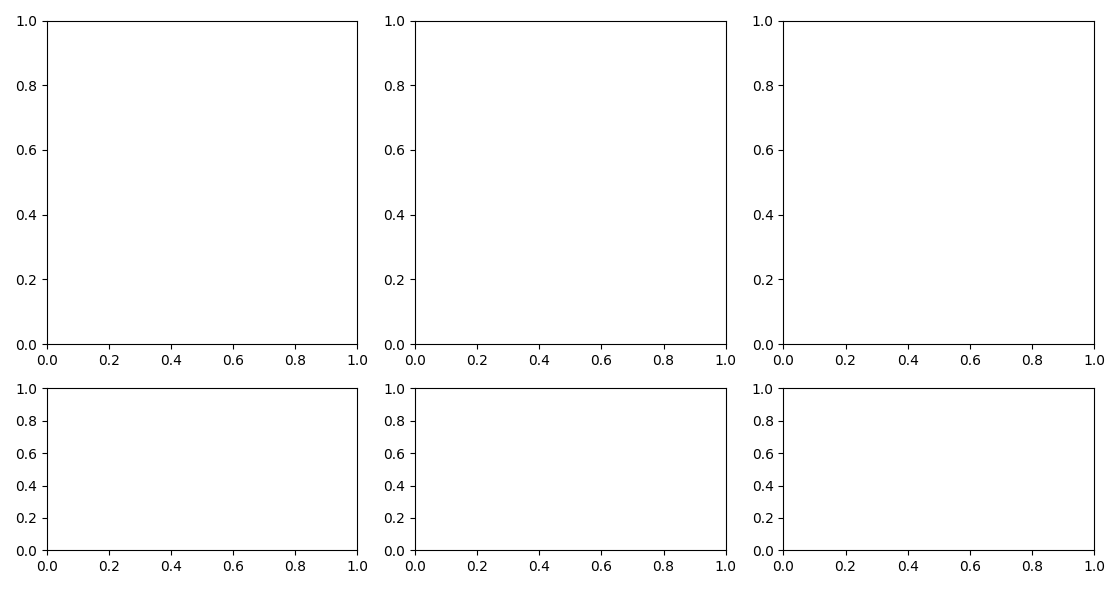

9.0
10.0
10.0
9.0
9.0
10.0
9.0
9.0
10.0


In [100]:
# Best Agents this Run
fig = plt.figure(num="Best Agents this Run", clear=True, layout="tight")
axes = fig.subplots(2, 3, height_ratios=[2,1])
plt.show()
env = gym.make("CartPole-v1", render_mode="human")
for reward, i, ax in zip(*rewards_overall[-1].sort(descending=True, stable=True), axes.T): # type: ignore
    ax[0].title.set_text(f"Genome {i}(earned {reward:.2f})")
    g: Genome = gs[i]
    g.draw(ax[0])
    ax[1].matshow(g.adj_mat_full.to_dense())
    fig.canvas.draw()
    for _ in range(3):
        obs, _info = env.reset()
        total_reward = 0.0
        done = False
        while not done:
            action = g(torch.as_tensor(obs, device=device)).nan_to_num().round().int().item()
            obs, reward, term, trunc, _info = env.step(action)
            total_reward += reward  # type: ignore
            done = term or trunc
        g.reset_nodevals()
        print(total_reward)
env.close()

In [461]:
# tryna vectorize the population forward pass
from torch.func import stack_module_state, functional_call #type: ignore
gs = [Genome(x.nodes, x.connections) for x in gs]
params, buffers = stack_module_state(gs) #type: ignore
display((params, buffers))
n_models = len(gs)
base_model = deepcopy(gs[0]).to("meta")
def fmodel(params, buffers, x):
    functional_call(base_model, (params, buffers), (x,))
torch.vmap(fmodel)(params, buffers, torch.randn((n_models, 4), device=device))

({}, {})

RuntimeError: vmap: index_put_(self, *extra_args) is not possible because there exists a Tensor `other` in extra_args that has more elements than `self`. This happened due to `other` being vmapped over but `self` not being vmapped over in a vmap. Please try to use out-of-place operators instead of index_put_. If said operator is being called inside the PyTorch framework, please file a bug report instead.

In [413]:
plt.figure("Rewards").savefig("Rewards.png")
plt.figure("Best Agents this Run").savefig("Best Agents this Run.png")

In [415]:
plt.close("all")

In [ ]:
envs.close()
env.close()

NameError: name 'envs' is not defined

In [ ]:
# randomly mutating agent example
# connections: list[ConnectionGene] = [
#     ConnectionGene(NodePair(1, 4), 0.1),
#     ConnectionGene(NodePair(2, 4), 0.2),
#     ConnectionGene(NodePair(2, 5), -0.2),
#     ConnectionGene(NodePair(1, 5), -.6),
#     ConnectionGene(NodePair(1, 4), -.4),
#     ConnectionGene(NodePair(2, 4), .7),
#     ConnectionGene(NodePair(2, 5), 0.3),
#     ConnectionGene(NodePair(1, 5), 1, False),
# ]
# g: Genome = Genome([NodeType.INPUT, NodeType.INPUT, NodeType.HIDDEN,
#                    NodeType.HIDDEN, NodeType.OUTPUT], connections)
g: Genome = Genome.new_initial(4, 1)
print(g.adj_mat_full)
fig: Figure = plt.figure(num="Randomly Mutating", clear=True)
ax1, ax2 = fig.subplots(1, 2) #type: ignore
g.draw(ax1)
plt.show(True)
env = gym.make("CartPole-v1", render_mode="human")
obs, _info = env.reset()
env.render()
for _ in range(500):
    obs, _reward, term, trunc, _info = env.step(
        bool(g(torch.tensor(obs, device=device)).cpu().numpy())
    )
    if term or trunc:
        env.reset()
        redraw = True
        if torch.rand(1) > 0.8:
            g.add_node()
        elif torch.rand(1) > 0.6:
            if not g.add_connection(): redraw = False
        elif torch.rand(1) > 0.4:
            delta_weights = torch.normal(0, 0.25, (len(g.connections),))
            for x, delta_weight in zip(g.connections.values(), delta_weights):
                x.weight += delta_weight.item()
            g.calculate_evalution_info()
            
        if redraw:
            ax1.clear()
            ax2.clear()
            g.draw(ax1)
            ax2.matshow(g.adj_mat_full.to_dense())
            fig.canvas.draw()
        g.reset_nodevals()
env.close()
g.adj_mat_full

In [ ]:
# just crossover, no speciation
assert False, "probably use the one with the speciation, this is just for posterity"
GLOBAL_INNOVATION_INCREMENT = count()
INITIAL_POP_SIZE: int = 50
MIN_EPISODES: int = 5
N_EPOCHS: int = 10
PARENTS_KEPT: int = 20
envs = gym.make_vec("CartPole-v1", INITIAL_POP_SIZE, "async")
gs: nn.ModuleList = nn.ModuleList(Genome.new_initial(4, 1) for _ in range(INITIAL_POP_SIZE))
gs.forward = lambda input: torch.tensor([x(y).round().bool() for x, y in zip(gs, input)])
rewards_overall = torch.zeros((N_EPOCHS, INITIAL_POP_SIZE), dtype=torch.float)
episodes = torch.zeros(INITIAL_POP_SIZE, dtype=torch.int)
curr_rewards = torch.zeros(INITIAL_POP_SIZE, dtype=torch.float)
for epoch in range(N_EPOCHS):
    epoch_rewards = rewards_overall[epoch]
    obs, _info = envs.reset()
    episodes.zero_()
    curr_rewards.zero_()
    while (episodes < MIN_EPISODES).any():
        input = torch.as_tensor(obs, device=device)
        actions = gs(input).cpu().numpy().astype(int)
        obs, rewards, terms, truncs, _infos = envs.step(actions)
        curr_rewards += rewards
        dones = terms | truncs
        if (dones).any():
            episodes[dones] += 1
            epoch_rewards[dones] += curr_rewards[dones]
            curr_rewards[dones] = 0
            for i in dones: gs[i].reset_nodevals()
    epoch_rewards /= episodes
    rewards_sorted, g_indices_sorted = epoch_rewards.sort(descending=True, stable=True)
    print(f"epoch {epoch} sorted rewards:\n{rewards_sorted}\nagents sorted:\n{g_indices_sorted}\n")
    if (epoch_rewards > 500).any():
        print(f"something's wrong, scores too high: {episodes}\n")
    if epoch < N_EPOCHS - 1:
        # parent_dist = torch.distributions.Categorical(rewards_sorted[:PARENTS_KEPT])
        # parent_pair_indices = parent_dist.sample(torch.Size((POP_SIZE, 2)))
        parent_pair_indices = torch.randint(PARENTS_KEPT, (INITIAL_POP_SIZE, 2))
        child_parents = g_indices_sorted[parent_pair_indices]
        child_parent_rewards = rewards_sorted[parent_pair_indices]
        # print(f"{rewards_sorted}\n{g_indices_sorted}\n{parents}\n{child_parents}")
        child_mutation_rates = torch.rand(INITIAL_POP_SIZE)
        parent1: Genome
        parent2: Genome
        for i in g_indices_sorted[PARENTS_KEPT:]:
            (parent1, parent2) = gs[child_parents[i][0]], gs[child_parents[i][1]] #type: ignore
            (parent1_reward, parent2_reward) = child_parent_rewards[i]
            g_new: Genome
            eq_fitness = torch.allclose(parent1_reward, parent2_reward)
            if parent1_reward >= parent2_reward:
                g_new = parent1.crossover(parent2, eq_fitness)
            else:
                g_new = parent2.crossover(parent1, eq_fitness)
            if child_mutation_rates[i] > 0.8: g_new.add_node()
            elif child_mutation_rates[i] > 0.5: g_new.add_connection()
            elif child_mutation_rates[i] > 0.3:
                delta_weights = torch.normal(0, 0.2, (len(g_new.connections),))
                for x, delta_weight in zip(g_new.connections.values(), delta_weights):
                    x.weight += delta_weight.item()
                g_new.calculate_evalution_info()
            gs[i] = g_new

envs.close()